In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# from unet import Unet
import gc
from tqdm import trange
from monai.networks.nets import UNet
from monai.losses import DiceLoss

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


def dice_coefficient(pred, target):
    assert pred.size() == target.size()

    sum_dim = (-1, -2, -3)
    eps = 1e-6

    intersection = 2 * (pred * target).sum(dim=sum_dim)
    sets_sum = pred.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, intersection, sets_sum)
    dice = (intersection + eps) / (sets_sum + eps)

    return dice.mean()


def dice_loss(pred, target):
    return 1 - dice_coefficient(pred, target)


def bce_dice_loss(input, target):
    bce = F.binary_cross_entropy_with_logits(input, target)
    smooth = 1e-5
    input = torch.sigmoid(input)
    num = target.size(0)
    input = input.view(num, -1)
    target = target.view(num, -1)
    intersection = input * target
    dice = (2.0 * intersection.sum(1) + smooth) / (
        input.sum(1) + target.sum(1) + smooth
    )
    dice = 1 - dice.sum() / num

    return 0.5 * bce + dice


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 0.001
# TODO: 2000 epochs
nepochs = 100
bs = 1
# n = 500

# model = Unet(input_channel=1).to(device)
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(sigmoid=True)

d = np.load("d.npy", allow_pickle=True).item()
imgs = d["imgs"]
masks = d["masks"]

# Normalize to [0, 255]
imgs = torch.tensor(
    np.round(
        (imgs - imgs.min(axis=(1, 2))[:, None, None])
        / (imgs.max(axis=(1, 2)) - imgs.min(axis=(1, 2)))[:, None, None]
        * 255
    )
).float()
masks = torch.tensor(masks).long()

imgs = imgs
masks = masks
n = len(imgs)

# Add one color channel dimension to all the images
imgs = imgs.unsqueeze(1)
masks = masks.unsqueeze(1)

train_size = int(0.7 * n)
val_size = int(0.2 * n)
test_size = n - train_size - val_size
train_size += n - (train_size + val_size + test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    list(zip(imgs, masks)),
    [train_size, val_size, test_size],
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=bs, shuffle=False
)

train_losses = []
val_losses = []
for epoch in (pbar := trange(nepochs)):
    model.train()
    train_loss = 0.0
    for i, (img, mask) in enumerate(train_dataloader):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(train_dataloader)}, loss: {loss.item()}"
        )
    train_losses.append(train_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    for i, (img, mask) in enumerate(val_dataloader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        loss = criterion(output, mask)
        val_loss += loss.item()
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(val_dataloader)}, loss: {loss.item()}"
        )
    val_losses.append(val_loss / len(val_dataloader))

Epoch 1/100, iteration 185/376, loss: 0.9972591996192932:   0%|          | 0/100 [00:34<?, ?it/s]  


KeyboardInterrupt: 

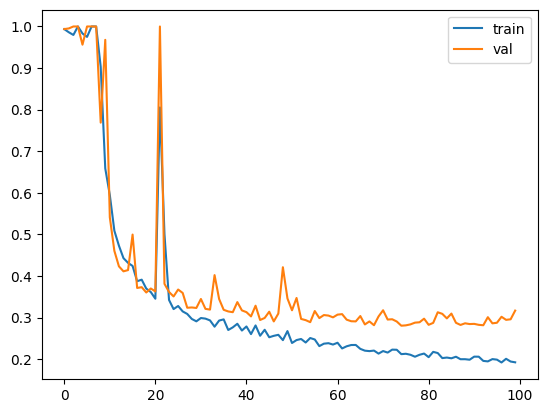

In [3]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [2]:
# torch.save(model.state_dict(), "./model-monai-100epoch-1500img.pth")

In [5]:
import torch
from monai.networks.nets import UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("./model-monai-100epoch-1500img.pth"))

<All keys matched successfully>

tensor(0.6438, device='cuda:0')


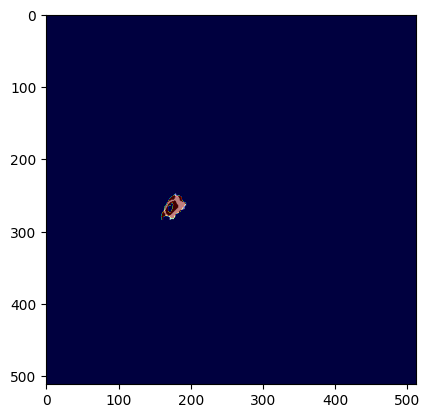

[0.5473684072494507, 0.8733944892883301, 0.9071038365364075, 8.333332601750953e-08, 0.6437768340110779, 0.9498806595802307, 0.8387096524238586, 0.25958701968193054, 0.884393036365509, 0.7125172019004822, 0.9016393423080444, 0.909547746181488, 0.40909096598625183, 0.8888888955116272, 0.9257950782775879, 0.7573872208595276, 0.903553307056427, 0.6391304135322571, 0.6372239589691162, 0.5714285969734192, 7.692307235629414e-08, 0.8813982605934143, 0.8402366638183594, 3.846153617814707e-08, 2.915451879914599e-09, 0.924369752407074, 0.964062511920929, 0.8771929740905762, 0.8772242069244385, 0.8737863898277283, 0.8586118221282959, 0.688330888748169, 0.7727272510528564, 0.7801857590675354, 7.1942447554818045e-09, 0.8586118221282959, 0.791946291923523, 3.3333321880490985e-07, 0.7932960987091064, 0.8936170339584351, 0.8567492961883545, 0.9146919250488281, 5.2631573765893336e-08, 0.880382776260376, 0.9562737345695496, 0.8984615206718445, 0.8295964002609253, 0.892307698726654, 0.87947016954422, 0.87

Text(0, 0.5, 'Dice coefficient')

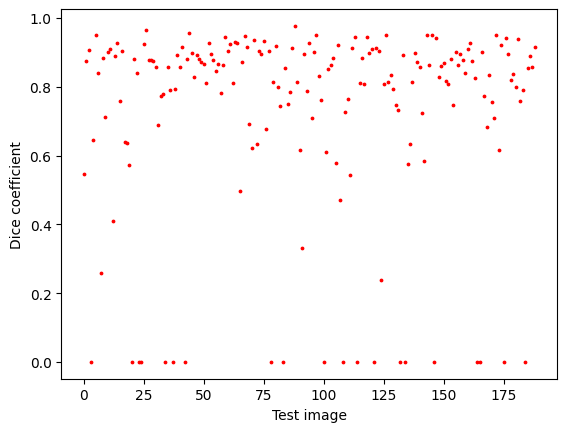

In [9]:
import torch
import matplotlib.pyplot as plt

plt.set_cmap("gray")

model.eval()

dices = []

with torch.no_grad():
    for i, (img, mask) in enumerate(test_dataloader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
        dice_coeff = dice_coefficient(output, mask)
        if i == 4:
            print(dice_coeff)
            plt.imshow(mask[0, 0].cpu().numpy(), cmap="gray")
            plt.imshow(output[0, 0].cpu().numpy(), cmap="jet", alpha=0.5)
            plt.show()
        dices.append(dice_coeff.item())


print(dices)
print(f"Average dice coefficient: {(sum(dices) / len(dices)):.2f}")
plt.scatter(np.arange(len(dices)), dices, s=3, c="red")
plt.xlabel("Test image")
plt.ylabel("Dice coefficient")